<a href="https://colab.research.google.com/github/justcherie/QD_Img_capt_plus_KG/blob/master/graphCNN_100_2x1024_dgl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
%cd /content/drive

In [0]:
!pwd
%cd '/content/drive/My Drive/tensorflow-tutorial/quickdraw_tfrecord'
!pwd
!ls

/content/drive/My Drive/tensorflow-tutorial/quickdraw_tfrecord
/content/drive/My Drive/tensorflow-tutorial/quickdraw_tfrecord
/content/drive/My Drive/tensorflow-tutorial/quickdraw_tfrecord
archive				    dgl_nx_25_combined_15cats_train.bin
archive-codebug			    dgl_nx_400_3cats_combined_test.bin
dgl_combined_100_test.bin	    dgl_nx_400_3cats_combined_train.bin
dgl_combined_100_train.bin	    dgl_nx_400_combined_15cats_test.bin
dgl_nx_25_combined_15cats_test.bin  dgl_nx_400_combined_15cats_train.bin


In [0]:
  label_dict = { 'alarm': 1 , 'clock': 2 , 'ambulance': 3 , 'angel': 4 , 'ant': 5 , 'barn': 6 , 'basket': 7 , 
'bee': 8 , 'bicycle': 9 , 'book':  10, 'bridge': 11 , 'bulldozer': 12 , 'bus': 13 , 'butterfly': 14 ,
 'cactus': 15 , 'castle': 16 , 'cat': 17 , 'chair': 18 , 'couch': 19 , 'crab':  20, 'cruise': 21,
 'ship': 22 , 'dolphin': 23 , 'duck': 24 , 'elephant': 25 , 'eye': 26 , 'face': 27 , 'fan': 28 , 'fire hydrant': 29 ,
 'firetruck': 30 , 'flamingo': 31 , 'flower':  32, 'garden':  33, 'hand': 34 , 'hedgehog':  35, 'helicopter': 36 , 'kangaroo': 37 , 'key': 38 ,
 'lighthouse': 39 , 'lion': 40 , 'map': 41 , 'mermaid': 42 , 'octopus': 43 , 'owl':  44, 'paintbrush':  45, 'palm tree': 46 , 'parrot': 47,
 'passport': 48 , 'peas':  49, 'penguin': 50 , 'pig':  51, 'pineapple': 52 , 'postcard': 53 , 'power outlet': 54 , 'rabbit':  55, 'radio': 56 ,
 'rain': 57 , 'rhinoceros':  58, 'roller coaster': 59 , 'sandwich': 60 , 'scorpion': 61, 'sea turtle':  62, 'sheep':  63, 'skull':  64, 'snail':  65,
 'snowflake':  66, 'speedboat': 67 , 'spider':  68, 'strawberry': 69 , 'swan': 70 , 'swing set': 71 , 'tennis racquet':  72, 'the mona lisa': 73 ,
 'toothbrush': 74 , 'truck': 75 , 'whale':  76, 'windmill': 77, 'airplane': 78, 'mosquito':79, 'yoga':80 }

In [0]:
# reference: https://docs.dgl.ai/tutorials/basics/4_batch.html

!pip install dgl
"""
.. currentmodule:: dgl

Batched Graph Classification with DGL
=====================================

**Author**: `Mufei Li <https://github.com/mufeili>`_,
`Minjie Wang <https://jermainewang.github.io/>`_,
`Zheng Zhang <https://shanghai.nyu.edu/academics/faculty/directory/zheng-zhang>`_.

Graph classification is an important problem
with applications across many fields -- bioinformatics, chemoinformatics, social
network analysis, urban computing and cyber-security. Applying graph neural
networks to this problem has been a popular approach recently (
`Ying et al., 2018 <https://arxiv.org/abs/1806.08804>`_,
`Cangea et al., 2018 <https://arxiv.org/abs/1811.01287>`_,
`Knyazev et al., 2018 <https://arxiv.org/abs/1811.09595>`_,
`Bianchi et al., 2019 <https://arxiv.org/abs/1901.01343>`_,
`Liao et al., 2019 <https://arxiv.org/abs/1901.01484>`_,
`Gao et al., 2019 <https://openreview.net/forum?id=HJePRoAct7>`_).

This tutorial demonstrates:
 * batching multiple graphs of variable size and shape with DGL
 * training a graph neural network for a simple graph classification task
"""

###############################################################################
# Simple Graph Classification Task
# --------------------------------
# In this tutorial, we will learn how to perform batched graph classification
# with dgl via a toy example of classifying 8 types of regular graphs as below:
#
# .. image:: https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/dataset_overview.png
#     :align: center
#
# We implement a synthetic dataset :class:`data.MiniGCDataset` in DGL. The dataset has 8
# different types of graphs and each class has the same number of graph samples.

from dgl.data import MiniGCDataset
import matplotlib.pyplot as plt
import networkx as nx
import os


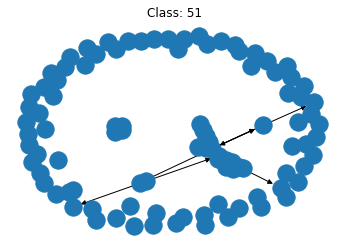

In [0]:
from dgl.data.utils import load_graphs
output_path = "/content/drive/My Drive/tensorflow-tutorial/quickdraw_tfrecord/"
file_name = "dgl_combined_100_train.bin"
glist, glabel_dict = load_graphs(os.path.join(output_path, file_name))

i=2
temp=tuple((glist[i],glabel_dict['label'].tolist()[i]))
#graph, label = dataset[0]
graph, label = temp
fig, ax = plt.subplots()
nx.draw(graph.to_networkx(), ax=ax)
ax.set_title('Class: {:d}'.format(label))
plt.show()


In [0]:
###############################################################################
# Form a graph mini-batch
# -----------------------
# To train neural networks more efficiently, a common practice is to **batch**
# multiple samples together to form a mini-batch. Batching fixed-shaped tensor
# inputs is quite easy (for example, batching two images of size :math:`28\times 28`
# gives a tensor of shape :math:`2\times 28\times 28`). By contrast, batching graph inputs
# has two challenges:
#
# * Graphs are sparse.
# * Graphs can have various length (e.g. number of nodes and edges).
#
# To address this, DGL provides a :func:`dgl.batch` API. It leverages the trick that
# a batch of graphs can be viewed as a large graph that have many disjoint
# connected components. Below is a visualization that gives the general idea:
#
# .. image:: https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/batch.png
#     :width: 400pt
#     :align: center
#
# We define the following ``collate`` function to form a mini-batch from a given
# list of graph and label pairs.

import dgl

def collate(samples):
    # The input `samples` is a list of pairs
    #  (graph, label).
    graphs, labels = map(list, zip(*samples))
    batched_graph = dgl.batch(graphs)
    return batched_graph, torch.tensor(labels)

###############################################################################
# The return type of :func:`dgl.batch` is still a graph (similar to the fact that
# a batch of tensors is still a tensor). This means that any code that works
# for one graph immediately works for a batch of graphs. More importantly,
# since DGL processes messages on all nodes and edges in parallel, this greatly
# improves efficiency.
#
# Graph Classifier
# ----------------
# The graph classification can be proceeded as follows:
#
# .. image:: https://s3.us-east-2.amazonaws.com/dgl.ai/tutorial/batch/graph_classifier.png
#
# From a batch of graphs, we first perform message passing/graph convolution
# for nodes to "communicate" with others. After message passing, we compute a
# tensor for graph representation from node (and edge) attributes. This step may
# be called "readout/aggregation" interchangeably. Finally, the graph
# representations can be fed into a classifier :math:`g` to predict the graph labels.
#

In [0]:
# Graph Convolution
# -----------------
# Our graph convolution operation is basically the same as that for GCN (checkout our 
# `tutorial <https://docs.dgl.ai/tutorials/models/1_gnn/1_gcn.html>`_). The only difference is
# that we replace :math:`h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)` by
# :math:`h_{v}^{(l+1)} = \text{ReLU}\left(b^{(l)}+\frac{1}{|\mathcal{N}(v)|}\sum_{u\in\mathcal{N}(v)}h_{u}^{(l)}W^{(l)}\right)`.
# The replacement of summation by average is to balance nodes with different
# degrees, which gives a better performance for this experiment.
#
# Note that the self edges added in the dataset initialization allows us to
# include the original node feature :math:`h_{v}^{(l)}` when taking the average.

import dgl.function as fn
import torch
import torch.nn as nn


# Sends a message of node feature h.
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    """Take an average over all neighbor node features hu and use it to
    overwrite the original node feature."""
    accum = torch.mean(nodes.mailbox['m'], 1)
    return {'h': accum}

class NodeApplyModule(nn.Module):
    """Update the node feature hv with ReLU(Whv+b)."""
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(node.data['h'])
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        # Initialize the node features with h.
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        return g.ndata.pop('h')


In [0]:
###############################################################################
# Readout and Classification
# --------------------------
# For this demonstration, we consider initial node features to be their degrees.
# After two rounds of graph convolution, we perform a graph readout by averaging
# over all node features for each graph in the batch
#
# .. math::
#
#    h_g=\frac{1}{|\mathcal{V}|}\sum_{v\in\mathcal{V}}h_{v}
#
# In DGL, :func:`dgl.mean_nodes` handles this task for a batch of
# graphs with variable size. We then feed our graph representations into a
# classifier with one linear layer to obtain pre-softmax logits.

import torch.nn.functional as F


class Classifier(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(Classifier, self).__init__()

        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
        self.classify = nn.Linear(hidden_dim, n_classes)

    def forward(self, g):
        # For undirected graphs, in_degree is the same as
        # out_degree.
        h = g.in_degrees().view(-1, 1).float()
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        hg = dgl.mean_nodes(g, 'h')
        return self.classify(hg)


In [0]:
###############################################################################
# Setup and Training
# ------------------
# We create a synthetic dataset of :math:`400` graphs with :math:`10` ~
# :math:`20` nodes. :math:`320` graphs constitute a training set and
# :math:`80` graphs constitute a test set.

import torch.optim as optim
from torch.utils.data import DataLoader

# Create training and test sets.
#trainset = MiniGCDataset(320, 10, 20)
#testset = MiniGCDataset(80, 10, 20)

from dgl.data.utils import load_graphs
output_path = "/content/drive/My Drive/tensorflow-tutorial/quickdraw_tfrecord"
file_name_train = "dgl_combined_100_train.bin"
glist_train, label_dict_train = load_graphs(os.path.join(output_path, file_name_train))
#i=2
#temp=tuple((glist[i],label_dict['label'].tolist()[i]))

import numpy as np
#trainset = tuple((glist_train,label_dict_train['label'].tolist()))
#trainset = np.array(([glist_train, label_dict_train['label'].tolist()])
trainset = list( zip( glist_train, label_dict_train['label'].tolist() ))

file_name_test = "dgl_combined_100_test.bin"
glist_test, label_dict_test = load_graphs(os.path.join(output_path, file_name_test))
testset = list( zip( glist_test, label_dict_test['label'].tolist() ))


Epoch 0, loss 2.5577
Epoch 1, loss 2.3341
Epoch 2, loss 2.3151
Epoch 3, loss 2.3081
Epoch 4, loss 2.3021
Epoch 5, loss 2.2947
Epoch 6, loss 2.2875
Epoch 7, loss 2.2894


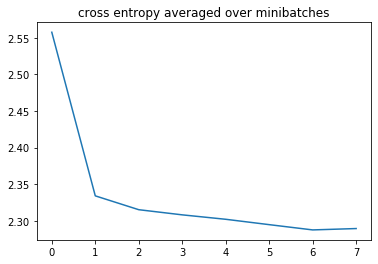

In [0]:

# Use PyTorch's DataLoader and the collate function
# defined before.
data_loader = DataLoader(trainset, batch_size=32, shuffle=True,
                         collate_fn=collate)

# Create model
#trainset_num_classes = len(np.unique(trainset[1]))
#from operator import itemgetter 
#trainset_num_classes = len(np.unique(list(map(itemgetter(1), trainset))))
trainset_num_classes = (len(label_dict.values())+1)
#model = Classifier(1, 256, trainset.num_classes)
model = Classifier(1, 1024, trainset_num_classes)

loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()

epoch_losses = []
num_epoches = 8
weights = []
labels_batch_run = []
for epoch in range(num_epoches):
    epoch_loss = 0
    for iter, (bg, label) in enumerate(data_loader):
        prediction = model(bg)
        loss = loss_func(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach().item()
       
    epoch_loss /= (iter + 1)
    print('Epoch {}, loss {:.4f}'.format(epoch, epoch_loss))
    epoch_losses.append(epoch_loss)

###############################################################################
# The learning curve of a run is presented below:

plt.title('cross entropy averaged over minibatches')
plt.plot(epoch_losses)
plt.show()


In [0]:
###############################################################################
# The trained model is evaluated on the test set created. Note that for deployment
# of the tutorial, we restrict our running time and you are likely to get a higher
# accuracy (:math:`80` % ~ :math:`90` %) than the ones printed below.

model.eval()
# Convert a list of tuples to two lists
test_X, test_Y = map(list, zip(*testset))
label_Y = test_Y
test_bg = dgl.batch(test_X)

test_Y = torch.tensor(test_Y).float().view(-1, 1)
probs_Y = torch.softmax(model(test_bg), 1)
sampled_Y = torch.multinomial(probs_Y, 1)
argmax_Y = torch.max(probs_Y, 1)[1].view(-1, 1)
print('Accuracy of sampled predictions on the test set: {:.4f}%'.format(
    (test_Y == sampled_Y.float()).sum().item() / len(test_Y) * 100))
print('Accuracy of argmax predictions on the test set: {:4f}%'.format(
    (test_Y == argmax_Y.float()).sum().item() / len(test_Y) * 100))


   

Accuracy of sampled predictions on the test set: 14.6263%
Accuracy of argmax predictions on the test set: 24.767677%


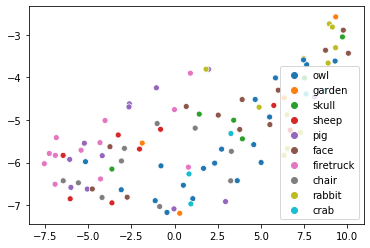

In [0]:

def plot_tsne(title,labels,word_tsne):
    import matplotlib.pyplot as plt
    
   
    plt.figure( figsize=[10,10])
    for i in range(len(word_tsne)):
        x = word_tsne[i,0]
        y = word_tsne[i,1]
#        plt.scatter(x, y, marker='x', color='red')
        plt.scatter(x, y, marker='o')
#        plt.text(x+0.3, y+0.3, labels[i], fontsize=9)
        plt.title(title)
    plt.show()
    
    return

from sklearn.manifold import TSNE
#layer_tsne = TSNE(n_components=2).fit_transform(model(test_bg).tolist())
#layer_tsne = TSNE(n_components=2).fit_transform(model(test_bg).tolist())

#plot_tsne("Y prior softmax",label_Y, layer_tsne)

eval_list = []
for graph in test_X[0:100]:
    eval_list.append(model.forward(graph).tolist())
    
layer_tsne = TSNE(n_components=2).fit_transform(eval_list)
#plot_tsne("Y prior softmax",label_Y, layer_tsne)

label_Y_text = []
for i in label_Y[0:100]:
    #label_Y_text.append(label_dict[label_Y[i]])
    
    label_Y_text.append( list(label_dict.keys())[list(label_dict.values()).index(label_Y[i])] )

import seaborn as sns
#iris = sns.load_dataset('iris')
sns.scatterplot(x=layer_tsne[:,0], y=layer_tsne[:,1],
              hue=label_Y_text)